In [1]:
import pandas as pd
import seaborn as sns

sns.set()

In [2]:
df = pd.read_csv('output.csv')
df["Correctness"] = df["Correctness"].map({0: "Incorrect", 1:"Correct"})
df['Correctness'] = pd.Categorical(df['Correctness'],
                                   categories=["Correct", "Incorrect"],
                                   ordered=True)
df['Order Difference'] = pd.Categorical(df['Order Difference'],
                                   categories=[-1, 0, 1],
                                   ordered=True)
df['Question ID'] = pd.Categorical(df['Question ID'],
                                   categories=sorted(df['Question ID'].value_counts().keys()),
                                   ordered=True)
df["Given-Expected Answer Pair"] = df.apply(lambda row:(row["Answer"], row["Correct Answer"]), axis=1)
# df["Given-Expected Answer Pair"] = pd.Categorical(df["Given-Expected Answer Pair"],
#                                                   categories=sorted(df["Given-Expected Answer Pair"].value_counts().keys()),
#                                                   ordered=True)


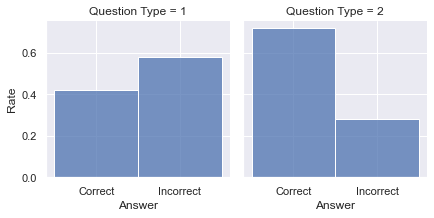

In [3]:
g = sns.FacetGrid(df, col = "Question Type")
graph = g.map_dataframe(sns.histplot, x = "Correctness", stat="probability")
graph.set_xlabels("Answer")
graph.set_ylabels("Rate")

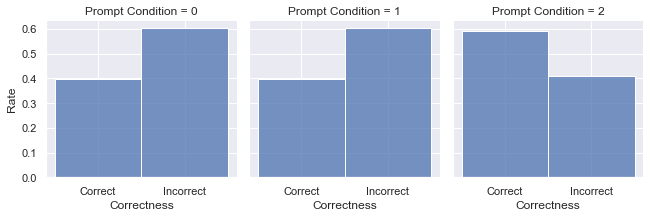

In [4]:
g = sns.FacetGrid(df[df["Question Type"] == 1], col = "Prompt Condition")
graph = g.map_dataframe(sns.histplot, x = "Correctness", stat="probability")
graph.set_xlabels("Correctness")
graph.set_ylabels("Rate")

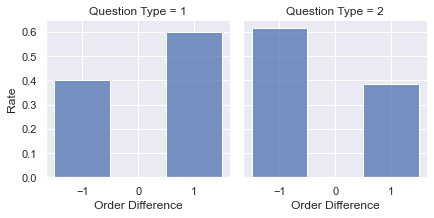

In [5]:
g = sns.FacetGrid(df[df["Order Difference"] != 0], col = "Question Type")
graph = g.map_dataframe(sns.histplot, x = "Order Difference", stat="probability")
graph.set_xlabels("Order Difference")
graph.set_ylabels("Rate")

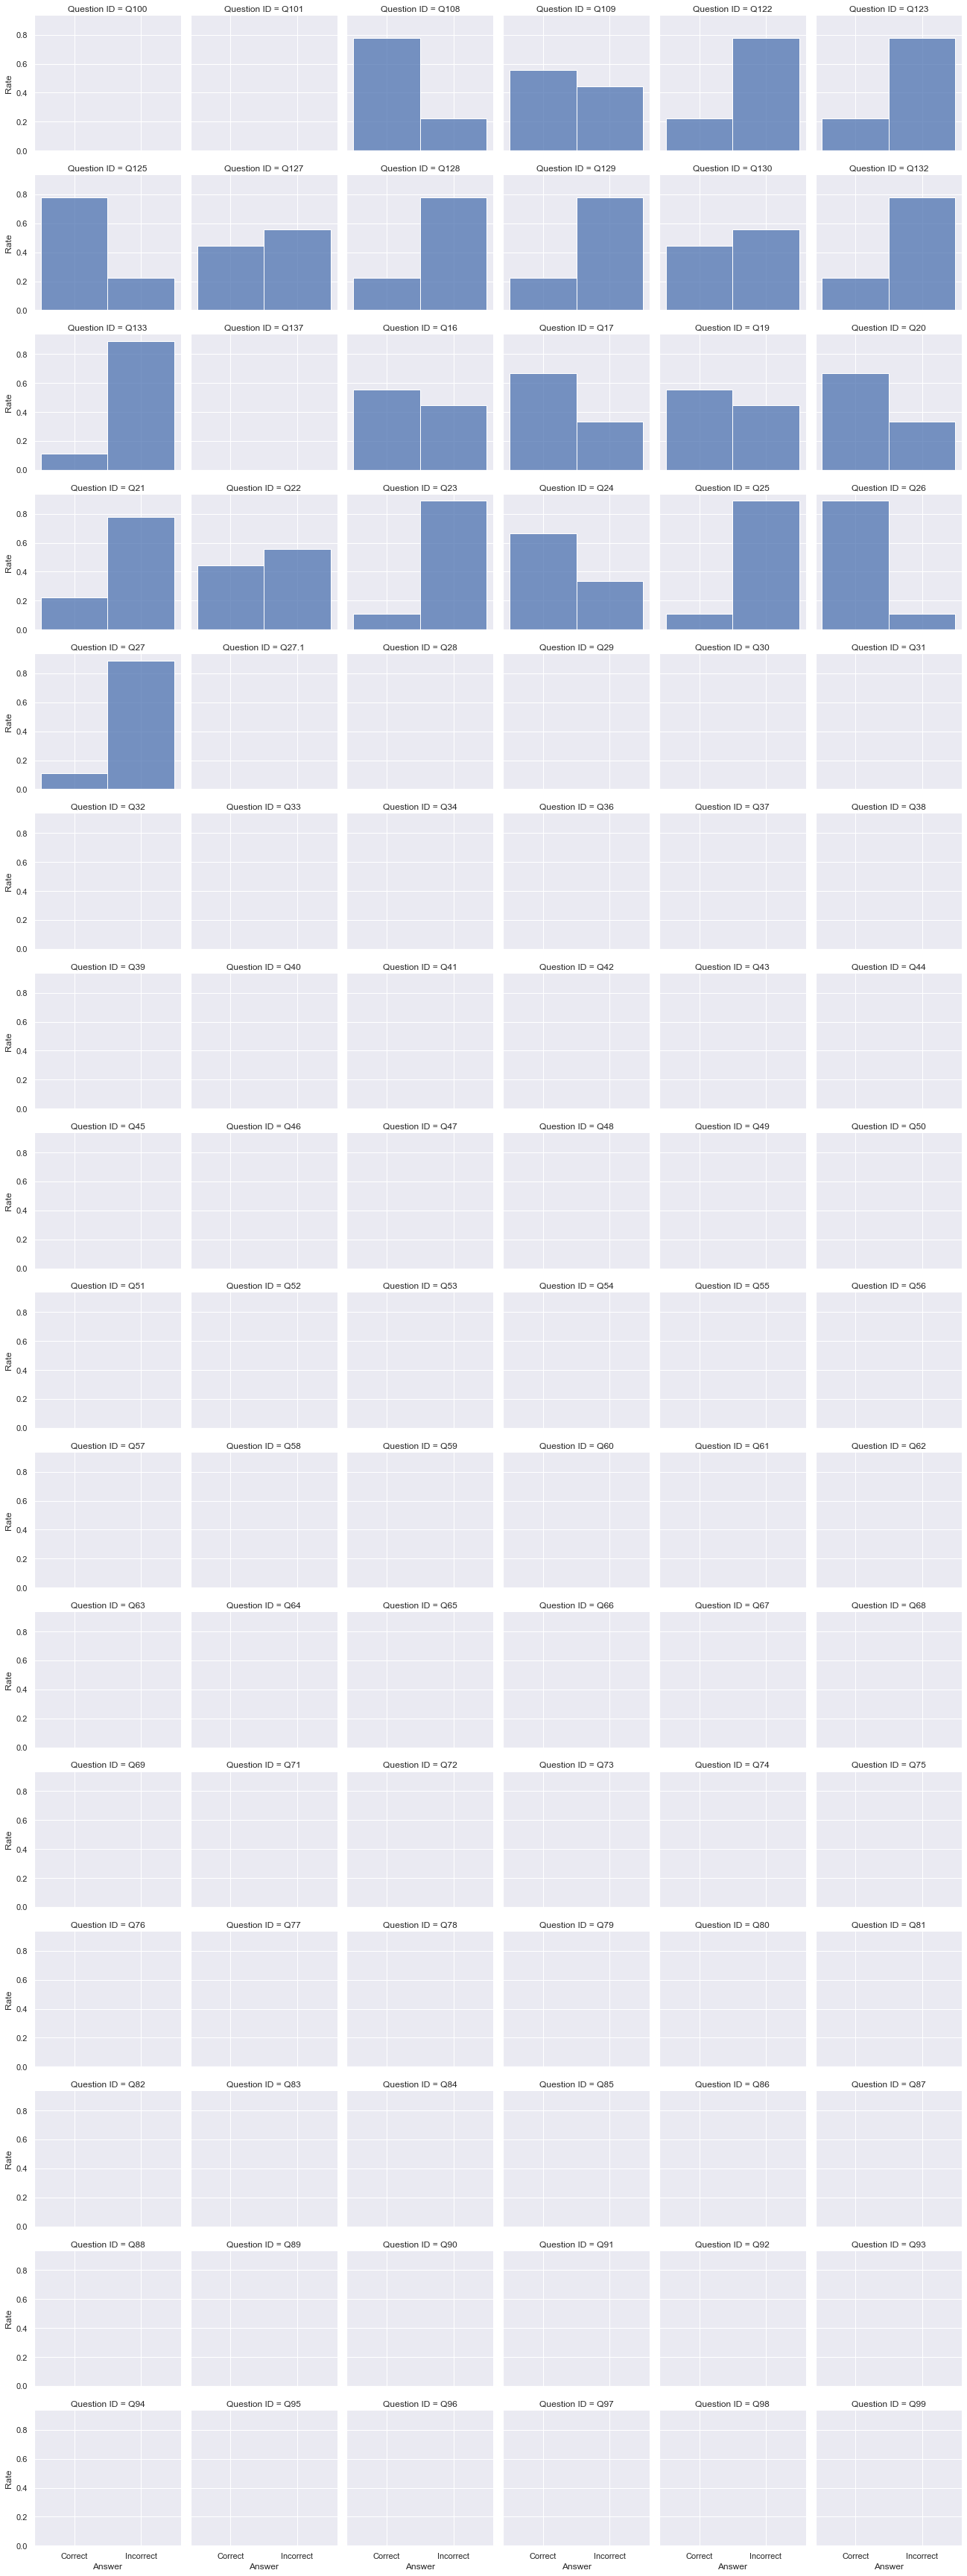

In [6]:
g = sns.FacetGrid(df[df["Question Type"] == 1], col = "Question ID", col_wrap=6)
graph = g.map_dataframe(sns.histplot, x = "Correctness", stat="probability")
graph.set_xlabels("Answer")
graph.set_ylabels("Rate")

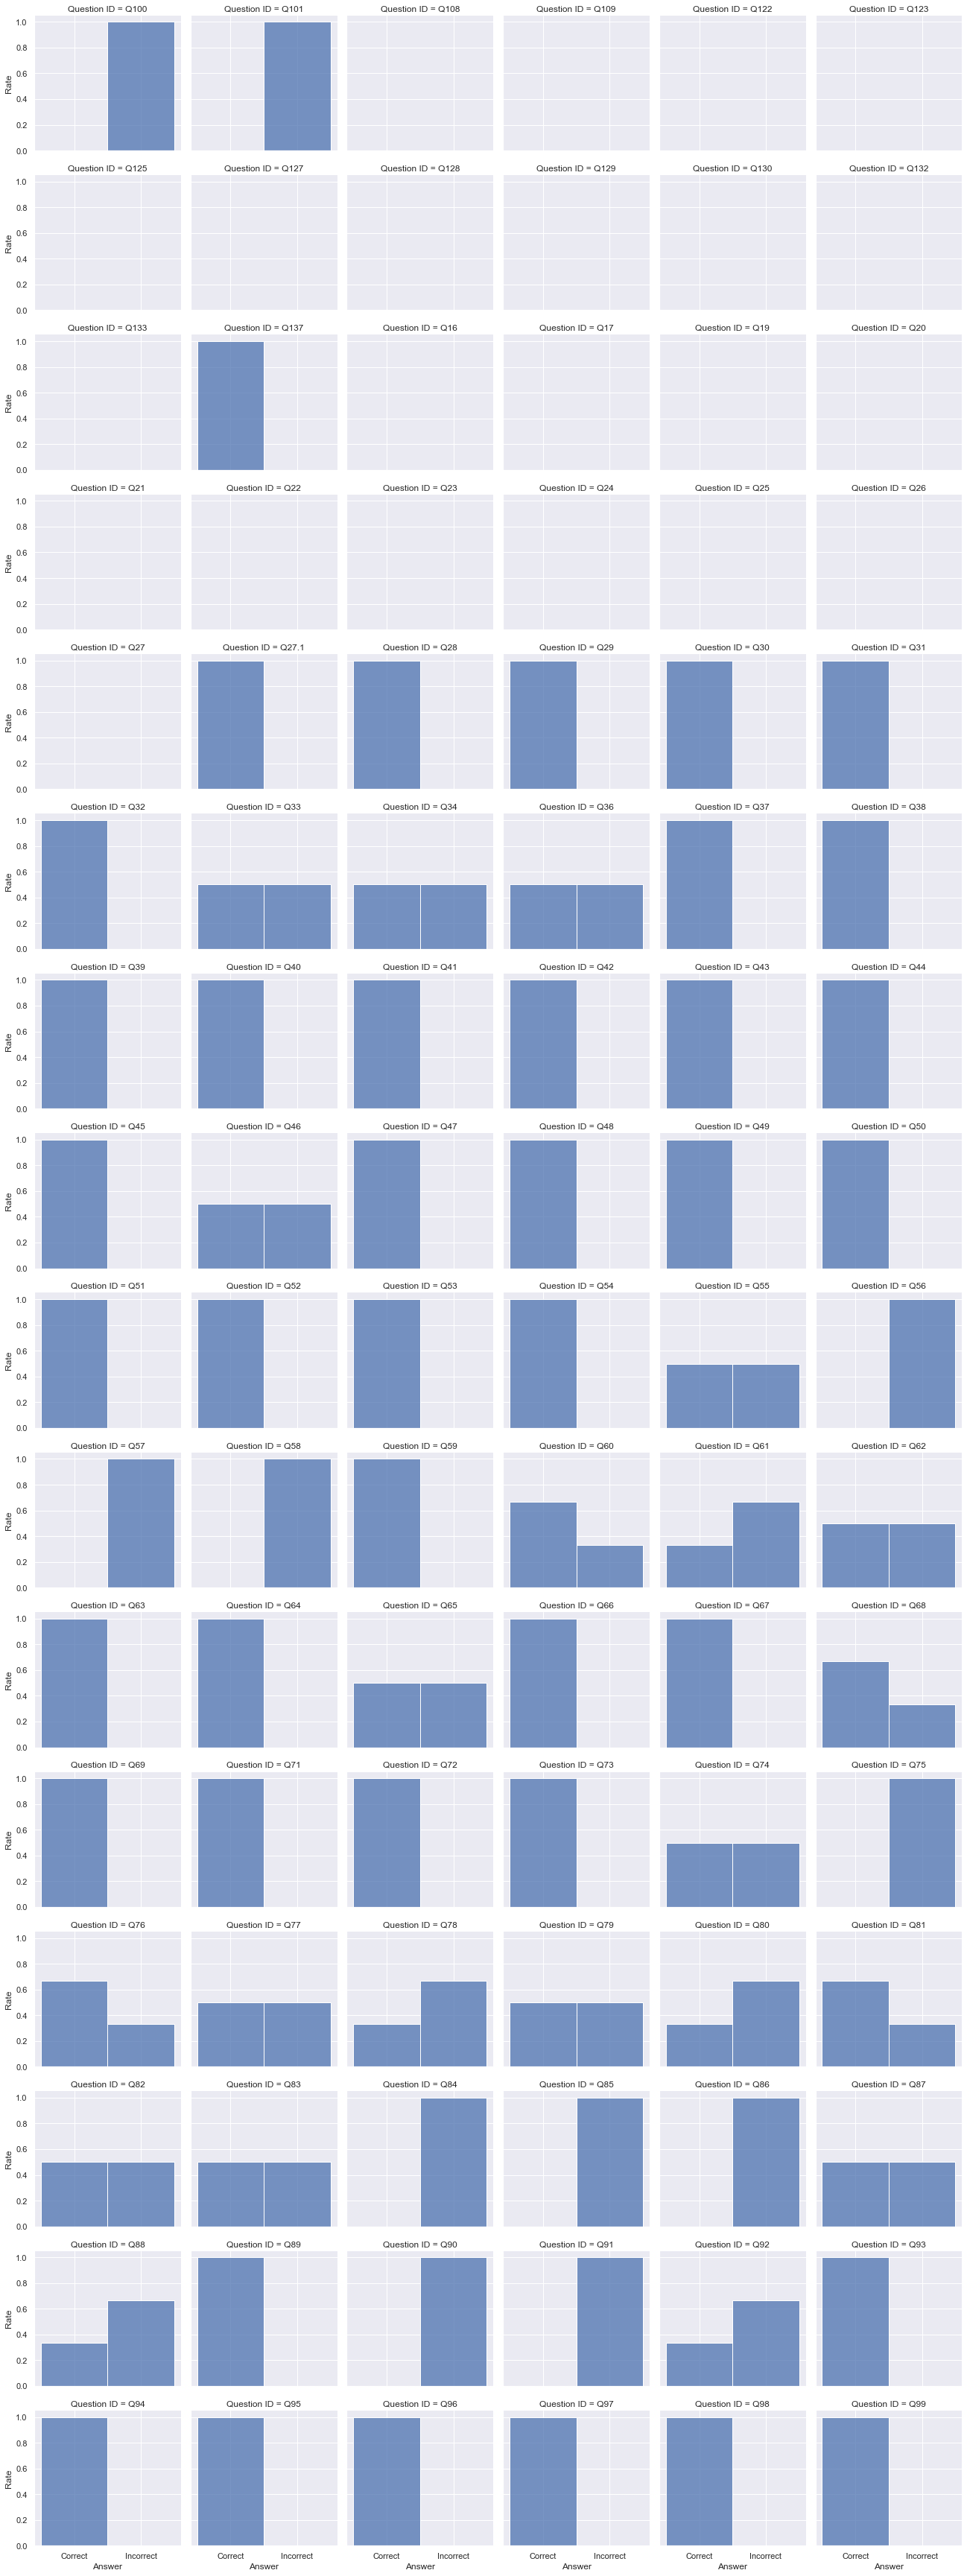

In [7]:
g = sns.FacetGrid(df[df["Question Type"] == 2], col="Question ID", col_wrap=6)
graph = g.map_dataframe(sns.histplot, x="Correctness", stat="probability")
graph.set_xlabels("Answer")
graph.set_ylabels("Rate")

Text(0.5, 0.98, 'Given-Expected Answer Pair')

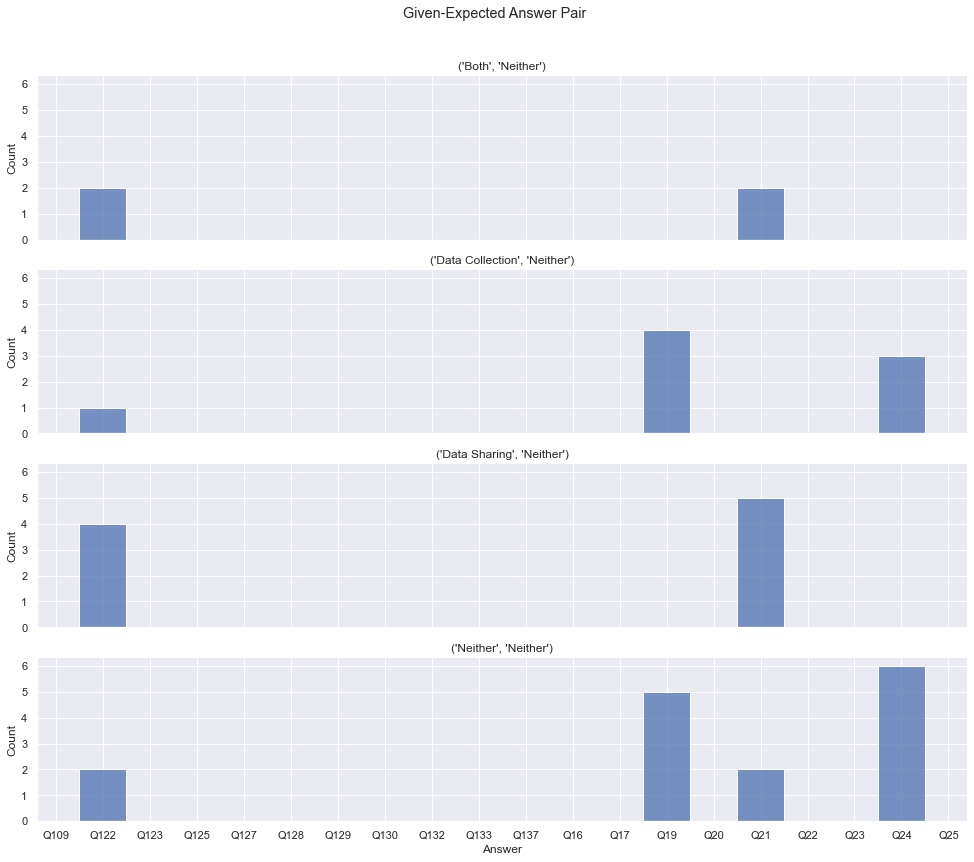

In [8]:
g = sns.FacetGrid(df[df["Correct Answer"] == "Neither"], col = "Given-Expected Answer Pair", col_wrap=1, aspect=4.5,
                 col_order=sorted(df[df["Correct Answer"] == "Neither"]["Given-Expected Answer Pair"].value_counts().keys()))
graph = g.map_dataframe(sns.histplot, x = "Question ID", stat="count")
graph.set_xlabels("Answer")
graph.set_ylabels("Count")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

# Add a title for the entire plot
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Given-Expected Answer Pair")